GMM decoding accuracy: 1.00


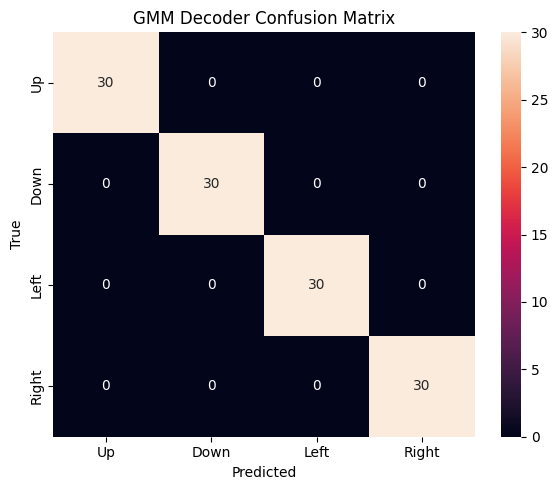

In [2]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
n_neurons = 10
n_classes = 4  # reach directions
n_trials_per_class = 100

# Simulate firing rates for each direction
means = np.random.rand(n_classes, n_neurons) * 10  # average firing rates
covs = [np.diag(np.random.rand(n_neurons) * 2 + 0.5) for _ in range(n_classes)]  # variability

# Generate spike count data
X = []
y = []

for label in range(n_classes):
    spikes = np.random.multivariate_normal(mean=means[label], cov=covs[label], size=n_trials_per_class)
    spikes = np.clip(spikes, a_min=0, a_max=None)  # no negative firing rates
    X.append(spikes)
    y.append(np.full(n_trials_per_class, label))

X = np.vstack(X)
y = np.concatenate(y)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Train GMM
gmm = GaussianMixture(n_components=n_classes, covariance_type='full', random_state=42)
gmm.fit(X_train)

# Predict by assigning to component with max posterior
y_pred = gmm.predict(X_test)

# Remap predicted labels to match true labels using majority voting
# (since GMM component indices are arbitrary)
from scipy.optimize import linear_sum_assignment

# Build confusion matrix between predicted clusters and true labels
conf = confusion_matrix(y_test, y_pred)
row_ind, col_ind = linear_sum_assignment(-conf)
label_map = {col: row for row, col in zip(row_ind, col_ind)}
y_pred_mapped = np.array([label_map[yi] for yi in y_pred])

# Evaluate
acc = accuracy_score(y_test, y_pred_mapped)
print(f"GMM decoding accuracy: {acc:.2f}")

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_mapped), annot=True, fmt='d',
            xticklabels=['Up', 'Down', 'Left', 'Right'],
            yticklabels=['Up', 'Down', 'Left', 'Right'])
plt.title("GMM Decoder Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


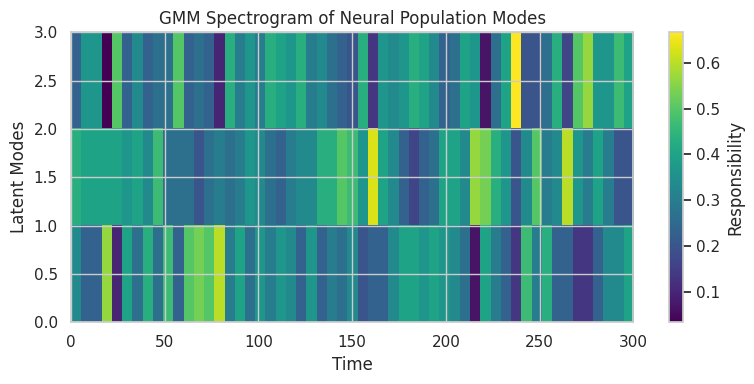

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.mixture import GaussianMixture
import seaborn as sns
    
# For nice plots
sns.set(style='whitegrid')

# --- Parameters ---
n_neurons = 10
n_modes = 3
time_steps = 300
window_size = 30
step_size = 5

# --- Simulate neural activity with mode switches ---
np.random.seed(1)

# Create mode-specific firing rate distributions
mode_means = np.array([
    np.random.uniform(2, 6, size=n_neurons),
    np.random.uniform(5, 10, size=n_neurons),
    np.random.uniform(1, 4, size=n_neurons),
])
mode_covs = [np.diag(np.random.rand(n_neurons) * 1.5 + 0.5) for _ in range(n_modes)]

# Simulate mode switches every 100 timesteps
true_modes = np.repeat(np.arange(n_modes), time_steps // n_modes)
np.random.shuffle(true_modes)  # optional: shuffle to simulate non-stationarity

data = np.zeros((time_steps, n_neurons))
for t in range(time_steps):
    m = true_modes[t]
    data[t] = np.random.multivariate_normal(mean=mode_means[m], cov=mode_covs[m])

# --- Run GMM over time windows ---
responsibilities = []

for t in range(0, time_steps - window_size + 1, step_size):
    window_data = data[t:t + window_size]
    gmm = GaussianMixture(n_components=n_modes, covariance_type='full', random_state=0)
    gmm.fit(window_data)
    gamma = gmm.predict_proba(window_data)  # shape: (window_size, n_modes)
    responsibilities.append(gamma.mean(axis=0))  # average soft assignment in this window

responsibilities = np.array(responsibilities)  # shape: (n_windows, n_modes)

# --- Plot as "spectrogram" ---
fig, ax = plt.subplots(figsize=(8, 4))
img = ax.imshow(responsibilities.T, aspect='auto', interpolation='nearest', cmap='viridis',
                extent=[0, time_steps, 0, n_modes])
ax.set_xlabel("Time")
ax.set_ylabel("Latent Modes")
ax.set_title("GMM Spectrogram of Neural Population Modes")
plt.colorbar(img, ax=ax, label="Responsibility")
plt.tight_layout()
plt.show()
